# Files list preparation

In [1]:
name_to_path = {
    'nia_2022_pos':'/home/jovyan/preprocessing_RNAModif/splits/20220303_hsa_dRNA_HeLa_5EU_polyA_REL5_2/test',
    'nia_2022_neg':'/home/jovyan/preprocessing_RNAModif/splits/20220520_hsa_dRNA_HeLa_DMSO_1/test',

    'nia_2020_pos':'/home/jovyan/preprocessing_RNAModif/splits/20201016_hsa_dRNASeq_HeLa_5EU_polyA_REL5_short_1/test',
    'nia_2020_neg':'/home/jovyan/preprocessing_RNAModif/splits/20201016_hsa_dRNASeq_HeLa_dmso_polyA_REL5_short_1/test',

    'nano_pos_1':'/home/jovyan/preprocessing_RNAModif/splits/20180514_1054_K562_5EU_1440_labeled_run/test',
    'nano_pos_2':'/home/jovyan/preprocessing_RNAModif/splits/20180514_1541_K562_5EU_1440_labeled_II_run/test',
    'nano_pos_3':'/home/jovyan/preprocessing_RNAModif/splits/20180516_1108_K562_5EU_1440_labeled_III_run/test',

    'nano_neg_1':'/home/jovyan/preprocessing_RNAModif/splits/20180327_1102_K562_5EU_0_unlabeled_run/test',
    'nano_neg_2':'/home/jovyan/preprocessing_RNAModif/splits/20180403_1102_K562_5EU_0_unlabeled_II_run/test',
    'nano_neg_3':'/home/jovyan/preprocessing_RNAModif/splits/20180403_1208_K562_5EU_0_unlabeled_III_run/test',

    #TODO get all 60 min datasets
    'nano_60pos_1':'/home/jovyan/preprocessing_RNAModif/splits/20180226_1208_K562_5EU_60_labeled_run/test',
}

name_to_label = {
    'nia_2022_pos':1,
    'nia_2022_neg':0,

    'nia_2020_pos':1,
    'nia_2020_neg':0,

    'nano_pos_1':1,
    'nano_pos_2':1,
    'nano_pos_3':1,

    'nano_neg_1':0,
    'nano_neg_2':0,
    'nano_neg_3':0,

    #TODO get all 60 min datasets
    'nano_60pos_1':1,
}

In [2]:
import pickle
from pathlib import Path

name_to_files = {}
for name, path in name_to_path.items():
    files = list(Path(path).rglob('*.fast5'))
    print(name, len(files))
    name_to_files[name] = files
    


nia_2022_pos 18
nia_2022_neg 43
nia_2020_pos 10
nia_2020_neg 16
nano_pos_1 1
nano_pos_2 4
nano_pos_3 1
nano_neg_1 4
nano_neg_2 4
nano_neg_3 3
nano_60pos_1 2


# Data module

In [3]:
from torch.utils.data import IterableDataset
from rnamodif.data_utils.read_utils import process_read
from rnamodif.data_utils.dataloading_5eu import ExhaustiveDataset
from ont_fast5_api.fast5_interface import get_fast5_file
        
window = 4096
stride = window - 1024

dset_map = {name:ExhaustiveDataset(files = files, window=window, stride=stride) for name,files in name_to_files.items()}


In [4]:
for k,v in dset_map.items():
    print(k)
    print(len(v.files))

nia_2022_pos
18
nia_2022_neg
43
nia_2020_pos
10
nia_2020_neg
16
nano_pos_1
1
nano_pos_2
4
nano_pos_3
1
nano_neg_1
4
nano_neg_2
4
nano_neg_3
3
nano_60pos_1
2


# Model loading


In [ ]:
# model = RodanPretrainedSeqcaller5eu()
# model

In [5]:
from rnamodif.rodan_seq_5eu import RodanPretrainedSeqcaller5eu
#Error = removed RELU, added batchnorm
checkpoint = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/5eu_2022_unfrozen_gru32_lowLR/last-Copy1.ckpt'
# checkpoint = '/home/jovyan/RNAModif/rnamodif/checkpoints_pl/nanoid2_frozen10_relufix/last.ckpt'
model = RodanPretrainedSeqcaller5eu().load_from_checkpoint(checkpoint)
# model

FREEZING 0 layers
FREEZING 0 layers


# Training

In [ ]:
from torch.utils.data import DataLoader
import pytorch_lightning as pl
preds_map = {}
for name, dataset in dset_map.items():
    print(name)
    #TODO utilize workers? Care for duplicate data!
    dataloader = DataLoader(dataset, batch_size=256)
    trainer = pl.Trainer(accelerator='gpu', precision=16)
    predictions = trainer.predict(model, dataloader)
    preds_map[name] = predictions
print('DONE')

nia_2022_pos


Using 16bit native Automatic Mixed Precision (AMP)
/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/loops/utilities.py:93: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

/home/jovyan/my-conda-envs/RNAmodEnvRod/lib/python3.8/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")


In [ ]:
import pickle
with open('5eu_all_unfrozen_lowLR_32.pickle', 'wb') as handle:
    pickle.dump(preds_map, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Metrics

In [10]:
# with open(f'5eu_unfrozen_lowLR_32.pickle','rb') as f:
#     preds_map = pickle.load(f)
# for k,v in preds_map.items():
#     print(k, len(v))
# OLD SPLIT 

NIA_POS 3251
NIA_NEG 8802
NANOID_POS 4919
NANOID_NEG 18460


In [40]:
with open(f'5eu_nanoid_all_unfrozen_lowLR_32.pickle','rb') as f:
    preds_map = pickle.load(f)
for k,v in preds_map.items():
    print(k, len(v))

nano_pos_1 217
nano_pos_2 783
nano_pos_3 94
nano_neg_1 1027
nano_neg_2 1360
nano_neg_3 787
nano_60pos_1 362


In [70]:
preds_map_2.keys()

dict_keys(['NIA_POS', 'NIA_NEG', 'NANOID_POS', 'NANOID_NEG'])

In [72]:
with open(f'5eu_unfrozen_lowLR_32.pickle','rb') as f:
    preds_map_2 = pickle.load(f)

exp_readpred_2 = {}
name_to_label_2 = {'NIA_POS':1,'NIA_NEG':0}
pooling = 'mean'
for exp in ['NIA_POS','NIA_NEG']:
    exp_readpred_2[exp] = predictions_to_read_predictions(preds_map_2[exp], label=name_to_label_2[exp], exp=exp, pooling=pooling)

In [24]:
with open(f'5eu_frozen10_chrsplit_wide_epoch=0-step=18000.pickle','rb') as f:
    preds_map = pickle.load(f)
with open(f'5eu_frozen10_chrsplit_wide_epoch=0-step=1800_negs.pickle','rb') as f:
    preds_map_neg = pickle.load(f)   
    
for k,v in preds_map_neg.items():
    preds_map[k] = v
    
for k,v in preds_map.items():
    print(k, len(v))

NIA_POS 6214
NIA_NEG 16915
NANOID_POS 18156
NANOID_NEG 9028


In [41]:
from collections import defaultdict
import numpy as np
def predictions_to_read_predictions(predictions, label, exp, pooling='mean'):
    id_to_preds = defaultdict(list)
    for pr, ids in predictions:
        readid_probs = zip(ids['readid'], pr.numpy())
        for readid, probab in readid_probs:
            id_to_preds[readid].append(probab)
                
    if(pooling == 'max'):
        for k,v in id_to_preds.items():
            id_to_preds[k] = {'predicted':np.array(v).max(), 'label':label, 'exp':exp}
        return id_to_preds
    if(pooling == 'mean'):
        for k,v in id_to_preds.items():
            id_to_preds[k] = {'predicted':np.array(v).mean(), 'label':label, 'exp':exp}
        return id_to_preds
    if(pooling == 'none'):
        id_to_preds_nopool = {}
        for k,v in id_to_preds.items():
            for i,prob in enumerate(v):
                id_to_preds_nopool[f'{k}_{i}'] = {'predicted':prob, 'label':label, 'exp':exp}
        return id_to_preds_nopool
    
    else:
        raise Exception(f'{pooling} pooling not implemented')

In [22]:
# preds_map['NIA_POS'][0][1]

In [73]:
exp_readpred = {}
pooling = 'mean'
for exp in preds_map.keys():
    exp_readpred[exp] = predictions_to_read_predictions(preds_map[exp], label=name_to_label[exp], exp=exp, pooling=pooling)

for k,v in exp_readpred.items():
    print(k, len(v))

nano_pos_1 3805
nano_pos_2 15120
nano_pos_3 1998
nano_neg_1 13787
nano_neg_2 15422
nano_neg_3 10550
nano_60pos_1 4955


In [74]:
from matplotlib import pyplot as plt
from sklearn import metrics
import numpy as np

def plot_roc(read_preds_list, title=''):
    id_to_preds = {key: value for d in read_preds_list for key, value in d.items()}
    # id_to_preds = predictions_to_read_predictions(dsets_preds, pooling)
    labels = [v['label'] for k,v in id_to_preds.items()]
    predictions = [v['predicted'] for k,v in id_to_preds.items()]
    exps = np.unique([v['exp'] for k,v in id_to_preds.items()])
    
    if(np.isnan(predictions).any()):
        print('Warning: Nan found in predictions, setting to 0')
        print(np.where(np.isnan(predictions)))
        for nan_idx in np.where(np.isnan(predictions))[0]:
            predictions[nan_idx] = 0.0
    
    fpr, tpr, thresholds = metrics.roc_curve(labels, predictions)
    cutoff_1 = thresholds[np.argmax(tpr-fpr)]
    cutoff_1_tpr = tpr[np.argmax(tpr-fpr)]
    
    cutoff_2 = thresholds[np.argmin((1-tpr) ** 2 + fpr ** 2)]
    cutoff_2_tpr = tpr[np.argmin((1-tpr) ** 2 + fpr ** 2)]
    
    try:
        auc = metrics.roc_auc_score(labels, predictions)
        precision, recall, thresholds = metrics.precision_recall_curve(labels, predictions)
    except ValueError:
        print('AUC not defined')
        auc=0
    
    exps = str(exps[:len(exps)//2])+'\n'+str(exps[len(exps)//2:]) #For nice legend printing
    plt.plot(fpr, tpr, label = f'{exps} \n AUC %.3f CUTOFFS {str(cutoff_1)[:4]} (tpr {str(cutoff_1_tpr)[:4]}) or {str(cutoff_2)[:4]} (tpr {str(cutoff_2_tpr)[:4]})' % auc)
    plt.title(f'{title}')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5), prop={'size':10})

    plt.xlim([0, 1.05])
    plt.ylim([0, 1.05])

In [80]:
for k,v in exp_readpred_2.items():
    print(k, len(v))
for k,v in exp_readpred.items():
    print(k, len(v))

NIA_POS 71467
NIA_NEG 169406
nano_pos_1 3805
nano_pos_2 15120
nano_pos_3 1998
nano_neg_1 13787
nano_neg_2 15422
nano_neg_3 10550
nano_60pos_1 4955


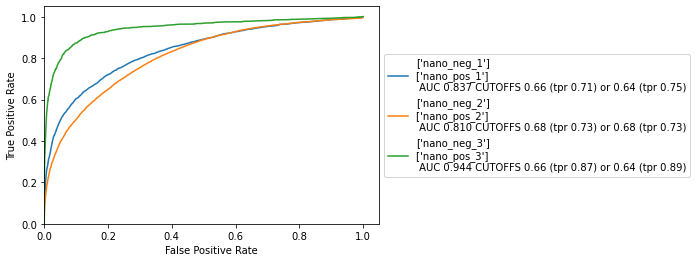

In [75]:
plot_roc([exp_readpred['nano_pos_1'], exp_readpred['nano_neg_1']])
plot_roc([exp_readpred['nano_pos_2'], exp_readpred['nano_neg_2']])
plot_roc([exp_readpred['nano_pos_3'], exp_readpred['nano_neg_3']])



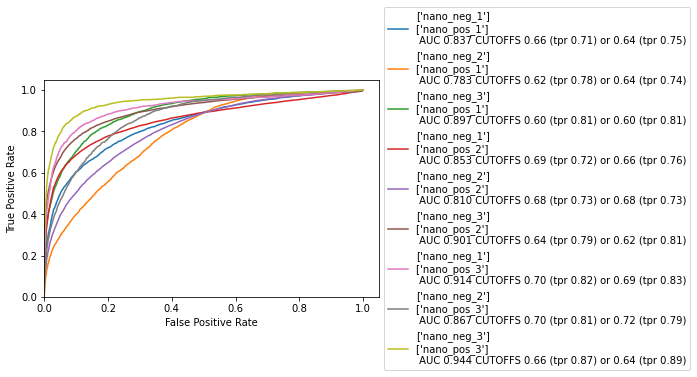

In [47]:
plot_roc([exp_readpred['nano_pos_1'], exp_readpred['nano_neg_1']])
plot_roc([exp_readpred['nano_pos_1'], exp_readpred['nano_neg_2']])
plot_roc([exp_readpred['nano_pos_1'], exp_readpred['nano_neg_3']])

plot_roc([exp_readpred['nano_pos_2'], exp_readpred['nano_neg_1']])
plot_roc([exp_readpred['nano_pos_2'], exp_readpred['nano_neg_2']])
plot_roc([exp_readpred['nano_pos_2'], exp_readpred['nano_neg_3']])

plot_roc([exp_readpred['nano_pos_3'], exp_readpred['nano_neg_1']])
plot_roc([exp_readpred['nano_pos_3'], exp_readpred['nano_neg_2']])
plot_roc([exp_readpred['nano_pos_3'], exp_readpred['nano_neg_3']])

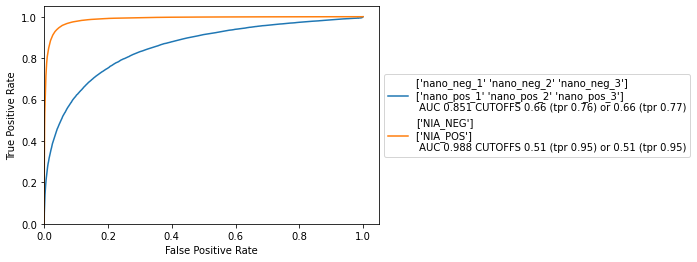

In [78]:
plot_roc([exp_readpred['nano_pos_1'], exp_readpred['nano_pos_2'], exp_readpred['nano_pos_3'], exp_readpred['nano_neg_1'], exp_readpred['nano_neg_2'], exp_readpred['nano_neg_3']])
plot_roc([exp_readpred_2['NIA_POS'], exp_readpred_2['NIA_NEG']])


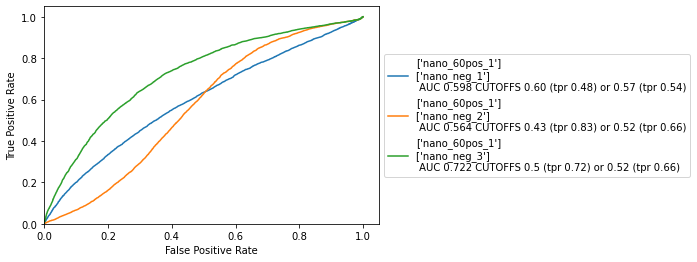

In [66]:
plot_roc([exp_readpred['nano_60pos_1'], exp_readpred['nano_neg_1']])
plot_roc([exp_readpred['nano_60pos_1'], exp_readpred['nano_neg_2']])
plot_roc([exp_readpred['nano_60pos_1'], exp_readpred['nano_neg_3']])